In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import xarray as xr
import numpy as np
import pandas as pd
import glob
import calendar
import seaborn as sns
import seaborn_image as isns
import string

In [2]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

In [3]:
import plotly.io as pio
pio.renderers.default='jupyterlab'

In [4]:
plt.style.use('seaborn-pastel')
isns.set_context(mode="notebook", fontfamily="Times")
sns.set_context(font_scale=0.8)

In [5]:
base_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/DIC/DIC_amplitude_base.nc', decode_times=True)
oae_26 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/DIC/DIC_amplitude_oae.nc', decode_times=True)

In [6]:
base_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/DIC/DIC_amplitude_base.nc', decode_times=True)
oae_70 = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP3_7.0/DIC/DIC_amplitude_oae.nc', decode_times=True)

In [7]:
datasets = [base_26, oae_26, base_70, oae_70]

In [8]:
newsets = []

for dataset in datasets:
    dataset = dataset.DIC.isel(z=0).to_dataset(name='DIC')
    dataset = dataset.sel(time_counter=slice('2090', '2100'))
    newsets.append(dataset)

In [9]:
datadict = {
    'base_26' : newsets[0],
    'oae_26' : newsets[1],
    'base_70' : newsets[2],
    'oae_70' : newsets[3]
}

In [10]:
def max_dic(dic):
    month_length_baseline = dic.time_counter.dt.days_in_month
    dic = ((dic * month_length_baseline).resample(time_counter='M').sum() / month_length_baseline.resample(time_counter='M').sum())
    max_dic = dic.resample(time_counter='AS').max('time_counter')
    return(max_dic)

In [11]:
def min_dic(dic):
    month_length_baseline = dic.time_counter.dt.days_in_month
    dic = ((dic * month_length_baseline).resample(time_counter='M').sum() / month_length_baseline.resample(time_counter='M').sum())
    min_dic = dic.resample(time_counter='AS').min('time_counter')
    return(min_dic)

In [12]:
def amplitude(dic_max, dic_min):
    dic_amplitude = (dic_max - dic_min)
    dic_amplitude = dic_amplitude.DIC.mean(dim=('time_counter')).to_dataset(name='dic')
    return(dic_amplitude)

In [13]:
def plot_map(ampl, axn):
    im1 = ampl.dic.plot.pcolormesh( 
            ax=axn, 
            x="nav_lon", 
            y="nav_lat", 
            vmin=0,
            vmax=200,
            cmap=cmap,
            add_colorbar=False
        )
    return im1

In [14]:
def figchg(ampl, axn):
    im2 = ampl.dic.plot.pcolormesh( 
            ax=axn, 
            x="nav_lon", 
            y="nav_lat",
            vmin=-150,
            vmax=150,
            cmap=cmapdiff, 
            add_colorbar=False
        )
    return im2

In [15]:
base_26_max = max_dic(datadict['base_26'])
base_26_min = min_dic(datadict['base_26'])
oae_26_max = max_dic(datadict['oae_26'])
oae_26_min = min_dic(datadict['oae_26'])
base_70_max = max_dic(datadict['base_70'])
base_70_min = min_dic(datadict['base_70'])
oae_70_max = max_dic(datadict['oae_70'])
oae_70_min = min_dic(datadict['oae_70'])

In [16]:
base_26_ampl = amplitude(base_26_max, base_26_min)
oae_26_ampl = amplitude(oae_26_max, oae_26_min)
base_70_ampl = amplitude(base_70_max, base_70_min)
oae_70_ampl = amplitude(oae_70_max, oae_70_min)

In [17]:
ampl_26_chg = oae_26_ampl - base_26_ampl
ampl_70_chg = oae_70_ampl - base_70_ampl

In [18]:
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

In [19]:
cmapdiff = sns.diverging_palette(220, 20, as_cmap=True)

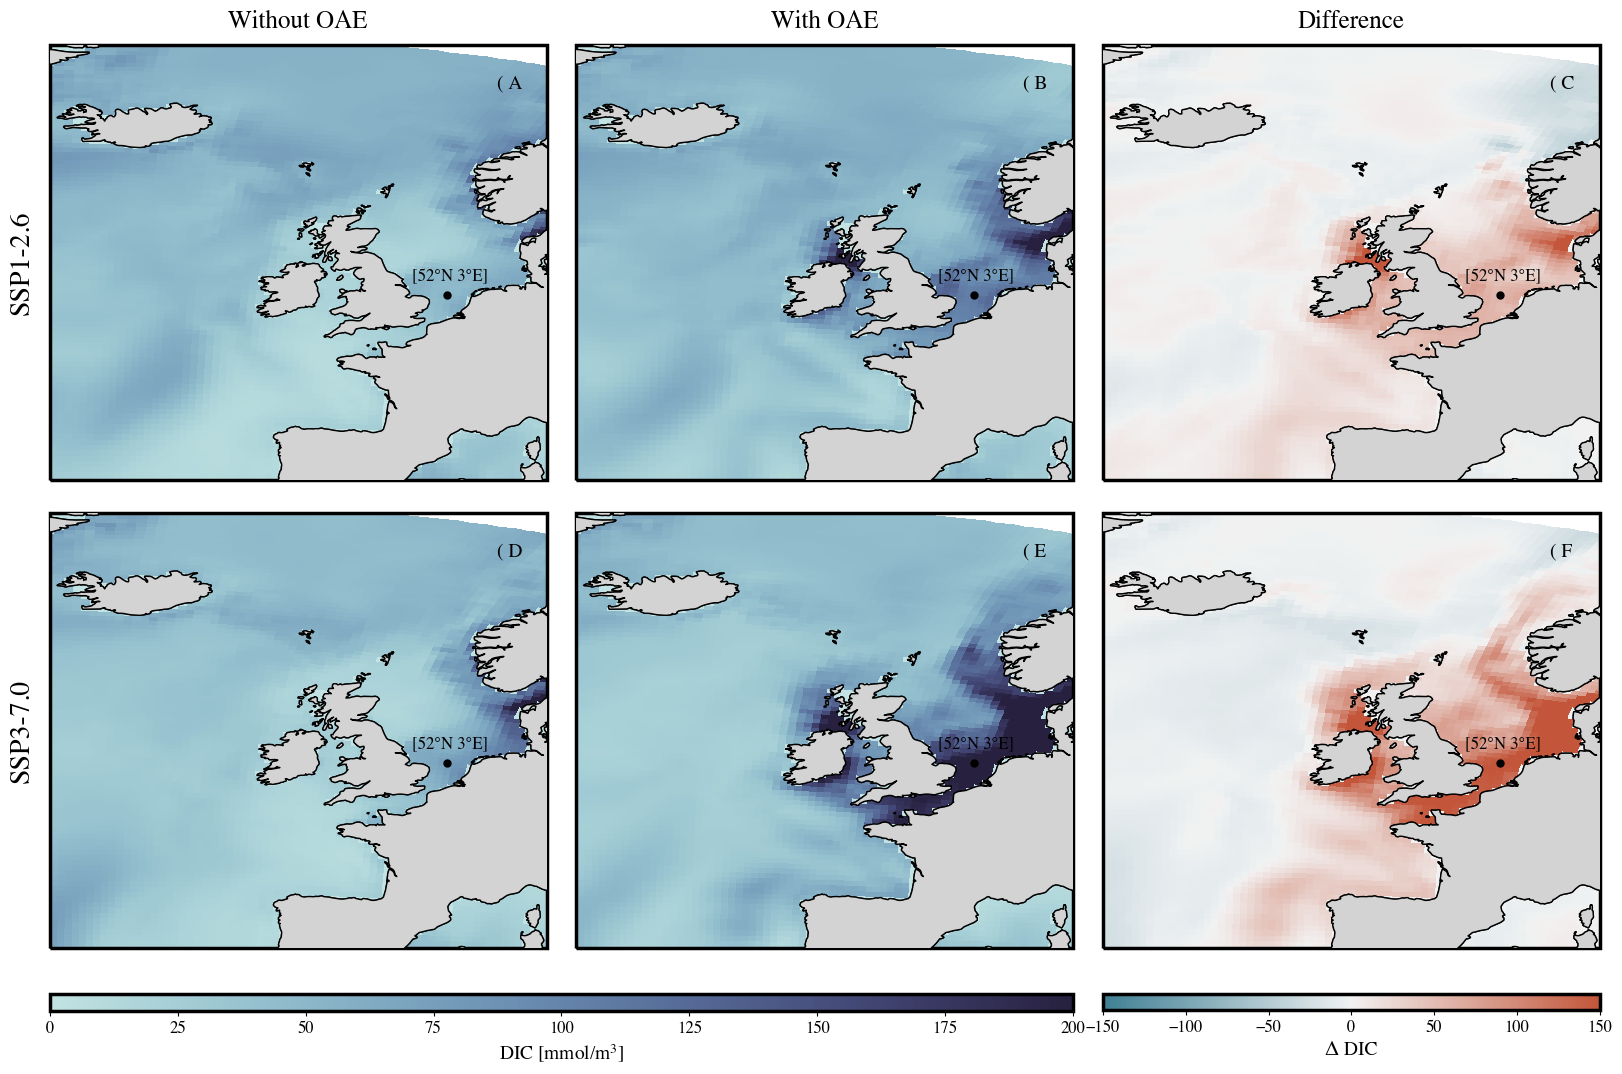

In [21]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20, 15))
plt.subplots_adjust(wspace=0.06, hspace=0)

im1 = plot_map(base_26_ampl, ax1)
plot_map(oae_26_ampl, ax2)
im2 = figchg(ampl_26_chg, ax3)
plot_map(base_70_ampl, ax4)
plot_map(oae_70_ampl, ax5)
figchg(ampl_70_chg, ax6)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for ax in axes:
    ax.coastlines()
    ax.set_extent([-25, 10, 40, 70])
    ax.add_feature(cfeature.LAND, zorder=100, facecolor='lightgrey', edgecolor='black')
    ax.plot(3, 53, "o", color='black', markersize=5)
    ax.text(0.5, 54,'[52°N 3°E]', fontsize=12, color='black')

for ax in axes: 
    if ax == ax1:
        ax.set_title("Without OAE", fontsize=18, y=1.02)
    elif ax == ax2:
        ax.set_title("With OAE", fontsize=18, y=1.02),
    elif ax == ax3:
        ax.set_title("Difference", fontsize=18, y=1.02),
    else:
        ax.set_title("", fontsize=16, y=1.02)
        
for n, ax in enumerate(axes):
    ax.text(0.9, 0.9, string.punctuation[7] + ' ' + string.ascii_uppercase[n], transform=ax.transAxes, 
            size=14, weight='bold', color='black')

cbar1 = fig.colorbar(im1, ax = [ax1, ax2, ax4, ax5], aspect = 60, pad=0.04, location='bottom')
cbar2 = fig.colorbar(im2, ax = [ax3, ax6], aspect = 30, pad=0.04, location='bottom')

cbars = [cbar1, cbar2]
    
for cbar in cbars:
    if cbar == cbar1:
        cbar.set_label('DIC [mmol/$\mathregular{m^3}$]', fontsize=14)
        cbar.ax.tick_params(labelsize=12)
    else:
        cbar.set_label('Δ DIC', fontsize=14)
        cbar.ax.yaxis.get_offset_text().set(size=14)
        cbar.ax.tick_params(labelsize=12)

ax.text(-102,85, 'SSP1-2.6', rotation=90, fontsize=20)
ax.text(-102,52, 'SSP3-7.0', rotation=90, fontsize=20)
        
pass

plt.savefig('/Users/chiaraciscato/Desktop/geomar/geomarcode/seasonal_analysis/final_figs/dic_amplitude.png')